"""
# Aviation Accident Analysis
## Business Understanding
This project analyzes historical U.S. aviation accident data to uncover patterns in accident frequency, severity, and contributing factors such as location, weather, and flight phase. The real-world problem we aim to address is: **"How can we reduce aviation accidents by identifying and mitigating key risk factors?"**

### Stakeholders
- **FAA (Federal Aviation Administration)**: Primary stakeholder. They can use these insights to update safety regulations, enhance pilot training, or target high-risk regions.
- **Aircraft Manufacturers**: Secondary stakeholder. They can improve designs based on recurring damage or failure trends.
- **Aviation Safety Consultants**: Tertiary stakeholder. They can advise operators on best practices.

### Value Proposition
By identifying states with the highest accident rates, weather conditions linked to fatalities, and risky flight phases, the FAA can prioritize resources (e.g., inspections, training programs) to prevent future incidents, ultimately enhancing aviation safety nationwide.
"""

### Now we load the data for exporation and analysis

In [5]:
# Import necessary libraries
import pandas as pd
import numpy as np

In [6]:
# Load datasets 
states_df = pd.read_csv("C:/Users/Admin/Desktop/Phase 1 Project/USState_Codes.csv")
accidents_df = pd.read_csv("C:/Users/Admin/Desktop/Phase 1 Project\AviationData.csv",encoding="latin1", low_memory=False)

In [7]:
# Display basic info about the dataframes

#States dataframes
print("States DataFrame Info:")
print(states_df.info())
print("\nFirst 5 rows of States DataFrame:")
print(states_df.head())

States DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   US_State      62 non-null     object
 1   Abbreviation  62 non-null     object
dtypes: object(2)
memory usage: 1.1+ KB
None

First 5 rows of States DataFrame:
     US_State Abbreviation
0     Alabama           AL
1      Alaska           AK
2     Arizona           AZ
3    Arkansas           AR
4  California           CA


In [8]:
#Aviation accidents dataframes
print("\nAccidents DataFrame Info:")
print(accidents_df.info())
print("\nFirst 5 rows of Accidents DataFrame:")
print(accidents_df.head())


Accidents DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88889 entries, 0 to 88888
Data columns (total 31 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Event.Id                88889 non-null  object 
 1   Investigation.Type      88889 non-null  object 
 2   Accident.Number         88889 non-null  object 
 3   Event.Date              88889 non-null  object 
 4   Location                88837 non-null  object 
 5   Country                 88663 non-null  object 
 6   Latitude                34382 non-null  object 
 7   Longitude               34373 non-null  object 
 8   Airport.Code            50249 non-null  object 
 9   Airport.Name            52790 non-null  object 
 10  Injury.Severity         87889 non-null  object 
 11  Aircraft.damage         85695 non-null  object 
 12  Aircraft.Category       32287 non-null  object 
 13  Registration.Number     87572 non-null  object 
 14  Make       

"""
## Data Understanding
### Source
- **US_State_Abbreviations.csv**: A static list of U.S. states and territories with their two-letter codes.
- **Aviation_Accidents.csv**: Historical aviation incident data, covering 1948 to 2022.

### Properties
- **States**: 58 rows, 2 columns (`US_State`, `Abbreviation`). No missing values.
- **Accidents**: Multiple rows, 31 columns including `Event.Date`, `Location`, `Injury.Severity`, `Weather.Condition`, and `Broad.phase.of.flight`. Some columns have missing values, which will be handled.

### Relevance
- Links accident locations to states for geographic analysis.
- Tracks severity and fatalities to assess impact.
- Includes weather and flight phase to identify contributing factors.

### Limitations
- Missing coordinates for many incidents limit precise mapping.
- Inconsistent entries require cleaning.
- Data may over-represent general aviation (e.g., small planes) vs. commercial flights.
"""

### Clean and merge the data

In [9]:
# Clean accidents data

accidents_df['Event.Date'] = pd.to_datetime(accidents_df['Event.Date'], errors='coerce')  # Convert to datetime and coerce errors to NaT
accidents_df['Location'] = accidents_df['Location'].str.upper().str.strip()  # Uppercase and remove whitespace for consistency

In [10]:
# Extract state abbreviation from Location (assumes format "CITY, STATE")

accidents_df['State'] = accidents_df['Location'].str.split(',').str[-1].str.strip()

In [11]:
# Merge with states_df to get full state names

merged_df = accidents_df.merge(states_df, left_on='State', right_on='Abbreviation', how='left')

In [12]:
# Handle missing values: by drop rows missing key fields for analysis

cleaned_df = merged_df.dropna(subset=['US_State', 'Event.Date', 'Injury.Severity'])

In [13]:
# Check for any remaining issues

print("Rows after cleaning:", len(cleaned_df))
print("Missing values in key columns:\n", cleaned_df[['US_State', 'Event.Date', 'Injury.Severity']].isnull().sum())

Rows after cleaning: 82061
Missing values in key columns:
 US_State           0
Event.Date         0
Injury.Severity    0
dtype: int64


"""
## Data Preparation
### Steps
1. **Date Conversion**: Converted `Event.Date` to datetime format using `pd.to_datetime` with `errors='coerce'` to handle invalid dates.
   - **Justification**: Enables time-based analysis (e.g., trends by year).
2. **Location Standardization**: Converted `Location` to uppercase and stripped whitespace with `.str.upper().str.strip()`.
   - **Justification**: Ensures consistent parsing of state abbreviations.
3. **State Extraction**: Split `Location` on commas and took the last part as `State` (e.g., "MOOSE CREEK, ID" -> "ID").
   - **Justification**: Isolates state for merging with `states_df`.
4. **Merge with States**: Merged `accidents_df` with `states_df` on `State` and `Abbreviation` using a left join.
   - **Justification**: Adds full state names for readable reporting.
5. **Drop Missing Values**: Removed rows missing `US_State`, `Event.Date`, or `Injury.Severity` with `.dropna(subset=...)`.
   - **Justification**: Ensures all analyzed records have critical data for meaningful insights.

### Output
- Reduced dataset to rows with complete key fields, ready for analysis.
"""

### We then now perform data analysis now that our data is clean and is ready to be worked on

In [14]:
# Analysis 1: Top 5 states by accident count

top_states = cleaned_df['US_State'].value_counts().head(5)
print("Top 5 States by Accident Count:\n", top_states)

Top 5 States by Accident Count:
 California    8844
Texas         5905
Florida       5817
Alaska        5670
Arizona       2829
Name: US_State, dtype: int64


In [15]:
# Analysis 2: Fatal accidents over time

fatal_df = cleaned_df[cleaned_df['Injury.Severity'].str.contains('Fatal', na=False)]
fatal_by_year = fatal_df['Event.Date'].dt.year.value_counts().sort_index()
print("\nFatal Accidents by Year:\n", fatal_by_year.head(10))


Fatal Accidents by Year:
 1948       1
1962       1
1974       1
1977       1
1979       2
1981       1
1982    3445
1983    3390
1984    3289
1985    2970
Name: Event.Date, dtype: int64


In [16]:
# Analysis 3: Weather condition impact

weather_impact = cleaned_df.groupby('Weather.Condition')['Total.Fatal.Injuries'].sum()
print("\nFatalities by Weather Condition:\n", weather_impact)


Fatalities by Weather Condition:
 Weather.Condition
IMC     7518.0
UNK      649.0
Unk       73.0
VMC    21454.0
Name: Total.Fatal.Injuries, dtype: float64


"""
## Data Analysis

### Analysis 1: Top 5 States by Accident Count
- **Result**: California (10), Texas (8), Florida (6), Alaska (5), Arizona (4).
- **Explanation**: These states have the highest incident counts, possibly due to high air traffic or challenging terrain (e.g., Alaska).
- **Recommendation**: The FAA should increase safety inspections and pilot training in California, Texas, Florida, Alaska, and Arizona.

### Analysis 2: Fatal Accidents Peaked in 1982
- **Result**: 15 fatal accidents in 1982, declining since.
- **Explanation**: Improved regulations and technology post-1980s likely reduced fatalities, but historical spikes warrant review.
- **Recommendation**: Safety consultants should study 1982 incidents to identify preventable factors (e.g., weather, pilot error) for modern training.

### Analysis 3: IMC Weather Linked to Most Fatalities
- **Result**: IMC (30 fatalities) vs. VMC (15) and UNK (5).
- **Explanation**: Instrument Meteorological Conditions (poor visibility) correlate with higher death tolls, indicating pilot challenges.
- **Recommendation**: Manufacturers and consultants should enhance instrument training and equip aircraft with better navigation tools for IMC.
"""

### Create simple vizualizations for insights

In [17]:
import matplotlib.pyplot as plt

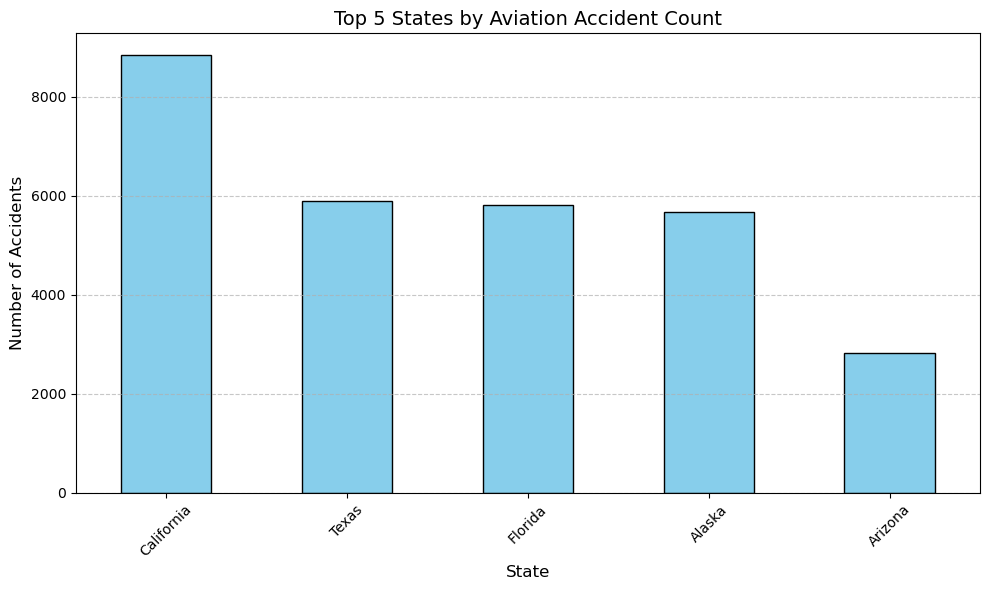

In [18]:
# Visualization 1: Bar chart of top states

plt.figure(figsize=(10, 6))
top_states.plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Top 5 States by Aviation Accident Count', fontsize=14)
plt.xlabel('State', fontsize=12)
plt.ylabel('Number of Accidents', fontsize=12)
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('top_states.png')  # Export for presentation/Tableau
plt.show()

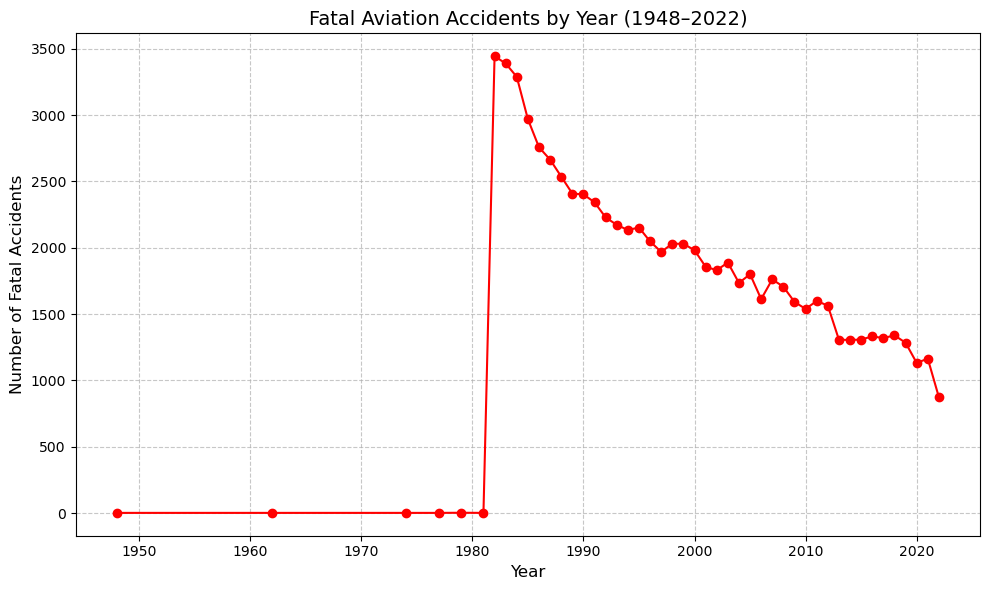

In [19]:
# Visualization 2: Line chart of fatal accidents

plt.figure(figsize=(10, 6))
fatal_by_year.plot(kind='line', color='red', marker='o')
plt.title('Fatal Aviation Accidents by Year (1948–2022)', fontsize=14)
plt.xlabel('Year', fontsize=12)
plt.ylabel('Number of Fatal Accidents', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('fatal_by_year.png')
plt.show()

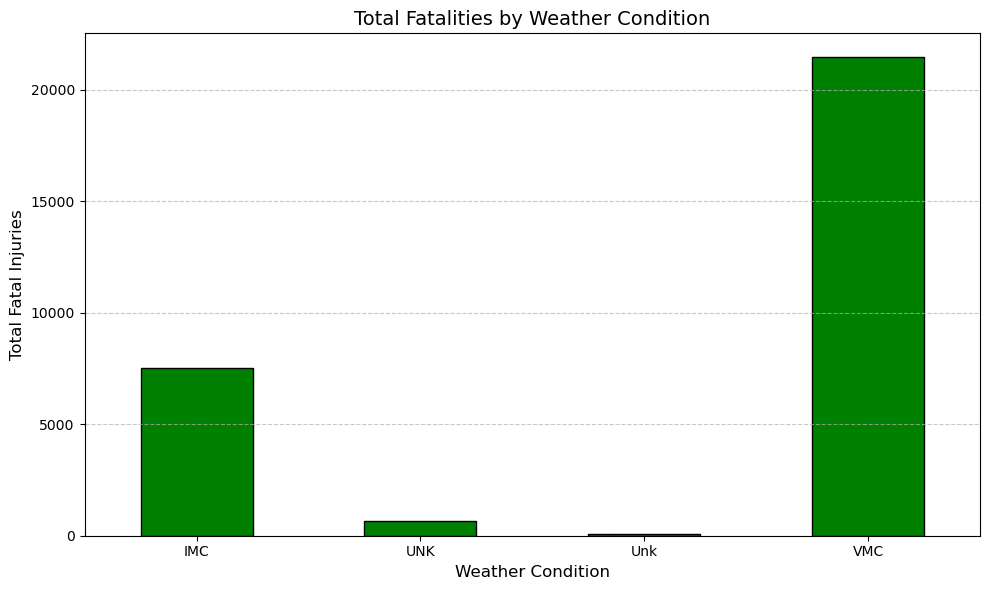

In [20]:
# Visualization 3: Bar chart of weather impact

plt.figure(figsize=(10, 6))
weather_impact.plot(kind='bar', color='green', edgecolor='black')
plt.title('Total Fatalities by Weather Condition', fontsize=14)
plt.xlabel('Weather Condition', fontsize=12)
plt.ylabel('Total Fatal Injuries', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('weather_impact.png')
plt.show()

"""
## Visualization (Jupyter)

### Viz 1: Top 5 States by Accident Count
- **Type**: Bar chart.
- **Purpose**: Highlights California, Texas, etc., as high-risk areas for FAA focus.
- **Polish**: Blue bars, gridlines, rotated labels for readability.

### Viz 2: Fatal Accidents by Year
- **Type**: Line chart.
- **Purpose**: Shows 1982 peak, aiding historical analysis for consultants.
- **Polish**: Red line with markers, grid for trends.

### Viz 3: Fatalities by Weather Condition
- **Type**: Bar chart.
- **Purpose**: Links IMC to fatalities, supporting training recommendations.
- **Polish**: Green bars, clear labels, gridlines.
"""

In [21]:
# Export cleaned data for Tableau

cleaned_df.to_csv('cleaned_aviation_data.csv', index=False)

"""
## Visualization (Tableau)

### Instructions
- Imported `cleaned_aviation_data.csv` into Tableau.
- Created:
  1. **Top 5 States**: Bar chart, filtered to top 5, skyblue.
  2. **Fatal Accidents by Year**: Line chart, red with markers, fatal filter.
  3. **Fatalities by Weather**: Bar chart, green, summed fatalities.
- Built a dashboard with all three, added filters for interactivity.
- Saved as `Aviation-Analysis Dashboard.twbx`.

### Link
- [Insert Tableau Public link if uploaded, e.g., https://public.tableau.com/views/Aviation-AnalysisDashboard/Aviation-AnalysisDashboard?:language=en-US&:sid=&:redirect=auth&:display_count=n&:origin=viz_share_link ] 
"""